In [ ]:
!pip install pysatproc
!pip install unetseg

In [ ]:
!pip install --force-reinstall numpy==1.20

In [ ]:
!pip install unetseg

# 2_ Predicción

In [1]:

ZONA = "TEGUCIGALPA"

BUCKET = f"gs://dym-quilmes-trucks-temp/I2UD/floods/{ZONA.lower()}/imagenes/dataset_*tif" 
BUCKET_RESULTS  = f"gs://dym-quilmes-trucks-temp/I2UD/floods/{ZONA.lower()}/results/" 
#satproc
BASE_PATH = "./.."
PATH_IMAGENES_PREDICCION = f'/images/{ZONA}/'

#unet
N_CHANNELS = 7
SIZE =130
STEP_SIZE = 40

CLASS_WEIGHT = [1]
STEP_PER_EPOCH = 100
N_CLASSES = 1
MODEL_NAME = f'UNet_{ZONA}_160x160_{str(SIZE)}_{str(STEP_SIZE)}_spe{STEP_PER_EPOCH}.h5'


##post-process
THR = 0.5
MIN_AREA = 1000




## Generación del data set de predicción

Descarga las imagenes del bucket

In [ ]:
#creamos la carpeta a donde descargaremos las imagenes
folder = BASE_PATH + PATH_IMAGENES_PREDICCION
!mkdir -p $folder
!gsutil -m cp -r $BUCKET   $folder

### Satproc

Con esta herramienta genereamos un dataset de imágenes de predicción que, a diferencia del de entrenamiento, solo contiene imágenes.

Pasamos la ruta de las imágenes de predicción y la ruta donde queremos que se guarde el resultado.



In [2]:
path_to_files         = f'{BASE_PATH}{PATH_IMAGENES_PREDICCION}*.tif' #carpeta a las imagenes
predict_output_folder = f'{BASE_PATH}/dataset/data_predict/{ZONA}/'+str(SIZE)+'_'+str(STEP_SIZE)+'/' #carpeta de destino del dataset
size = SIZE
step_size = SIZE

*Obs*: Dado que aquí nos interesa predecir sobre toda la imágen y por ende no tener overlaps,  *step_size* debe ser igual a *size*.

In [ ]:
#!satproc_extract_chips --help

In [3]:
!satproc_extract_chips \
                $path_to_files \
                -o  $predict_output_folder \
                --size $size \
                --step-size $step_size \
                --rescale \
                --rescale-mode percentiles --lower-cut 0 --upper-cut 100

Rasters:   0%|                                            | 0/1 [00:00<?, ?it/s]
dataset_global_tegucigalpa_epsg4326.tif windows:   0%|  | 0/195 [00:00<?, ?it/s]
dataset_global_tegucigalpa_epsg4326.tif windows:   8%| | 15/195 [00:00<00:01, 14
dataset_global_tegucigalpa_epsg4326.tif windows:  18%|1| 35/195 [00:00<00:00, 17
dataset_global_tegucigalpa_epsg4326.tif windows:  28%|2| 55/195 [00:00<00:00, 18
dataset_global_tegucigalpa_epsg4326.tif windows:  38%|3| 74/195 [00:00<00:00, 18
dataset_global_tegucigalpa_epsg4326.tif windows:  49%|4| 95/195 [00:00<00:00, 19
dataset_global_tegucigalpa_epsg4326.tif windows:  59%|5| 115/195 [00:00<00:00, 1
dataset_global_tegucigalpa_epsg4326.tif windows:  70%|6| 136/195 [00:00<00:00, 1
dataset_global_tegucigalpa_epsg4326.tif windows:  80%|8| 156/195 [00:00<00:00, 1
dataset_global_tegucigalpa_epsg4326.tif windows: 100%|#| 195/195 [00:01<00:00, 1
Rasters: 100%|####################################| 1/1 [00:01<00:00,  1.07s/it]


## Prediccion

In [4]:
from unetseg.predict import PredictConfig, predict
from unetseg.evaluate import plot_data_results
import os

2022-05-20 17:12:18.962676: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/cv2/../../lib64:
2022-05-20 17:12:18.962714: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Definimos la configuración para la predicción. Debemos pasar la ruta de las imágenes en el dataset de predicción, que es la ruta de salida de la línea anterior, y la correspondiente al modelo que entrenamos.

In [5]:

predict_config = PredictConfig(
                            images_path   = predict_output_folder, # ruta a las imagenes sobre las cuales queremos predecir
                            results_path  = os.path.join(BASE_PATH,'dataset/data_results',ZONA,str(SIZE)+"_"+str(STEP_SIZE)), # ruta de destino para nuestra predicción
                            batch_size    = 16,
                            model_path    = os.path.join(BASE_PATH,'data/weights',MODEL_NAME),  #  ruta al modelo (.h5)
                            height        = 160,
                            width         = 160,
                            n_channels    = N_CHANNELS,
                            n_classes     = N_CLASSES,
                            class_weights = CLASS_WEIGHT)


A continuación ejecutamos la predicción .

In [6]:
predict(predict_config)  # Ejecuta la predicción

Total images to predict (./../dataset/data_predict/TEGUCIGALPA/130_40/images/*.tif): 195
After skipping existing results: 195


2022-05-20 17:12:25.908982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-20 17:12:25.909900: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/cv2/../../lib64:
2022-05-20 17:12:25.910032: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/cv2/../../lib64:
2022-05-20 17:12:25.910138: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'

Done!


Podemos ver algunos resultados preliminares de la predicción. A la izquierda se encuentra la imágen y a la derecha, la predicción.

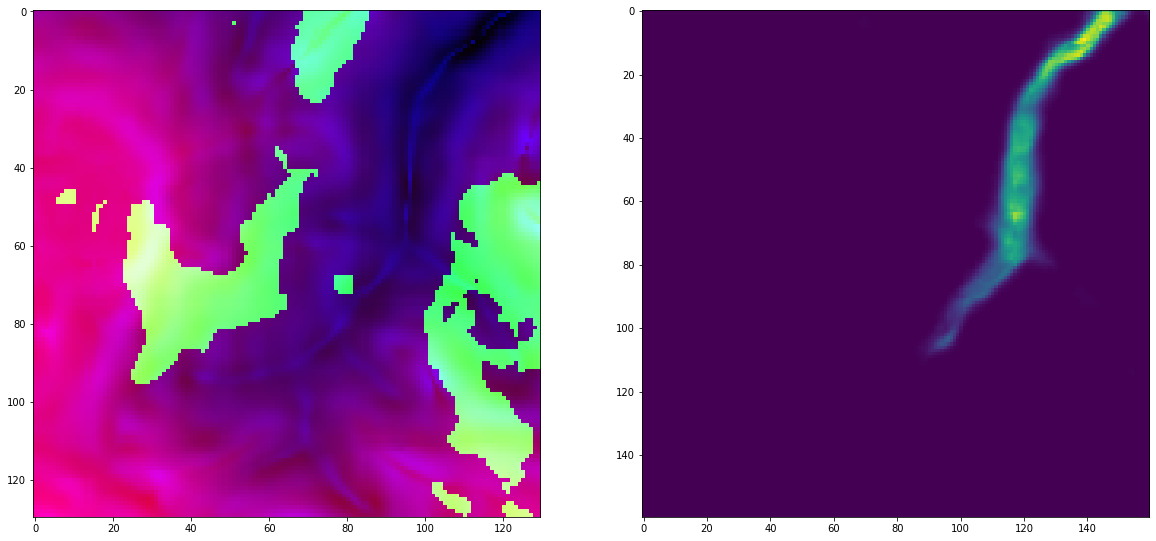

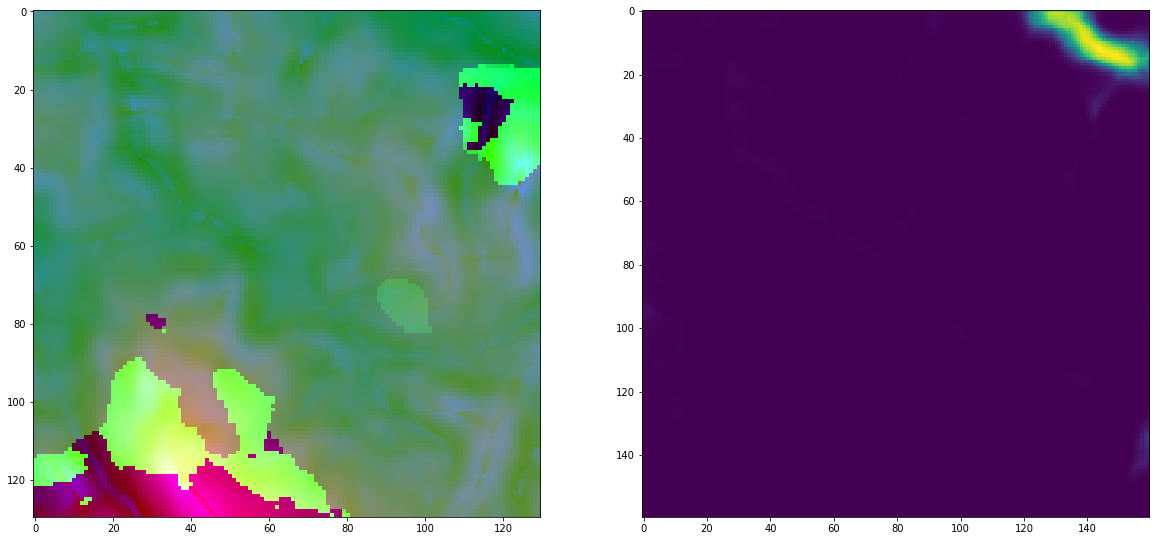

In [7]:
plot_data_results(num_samples=2, fig_size=(2, 2), predict_config=predict_config, img_ch =2, n_bands=3)

## Post procesamiento

En esta etapa se aplican los siguientes métodos de post-procesamiento a los resultados de la predicción realizada por el modelo:

* Filtrado por umbral
* Poligonizado

In [8]:
from satproc.postprocess.polygonize import polygonize 
from satproc.filter import filter_by_max_prob

**Filtrado por umbral**

En este proceso se realiza un filtrado de las imágenes mediante la aplicación de un umbral sobre los valores de los rásteres, que en este caso representan la probabilidad (valores entre 0 y 1), quedandonos así con las de mayor precisión.

In [9]:
thr = THR
str_thr = str(thr*10)

input_dir = predict_config.results_path
filter_folder = os.path.join(BASE_PATH,'dataset/data_results',ZONA,'filltered_thr_'+str_thr+'_'+str(SIZE)+'_'+str(STEP_SIZE)) # ruta de destino para nuestra predicción
                                 
!mkdir -p  $filter_folder

In [10]:
filter_by_max_prob(input_dir  = input_dir,
                   output_dir = filter_folder,
                   threshold  = thr)

100%|#############################################################| 195/195 [00:00<00:00, 369.35it/s]


**Poligonizado**

La siguiente función aplica una rutina de poligonización sobre los resultados de la predicción del modelo y genera un archivo vectorial en formato GeoPackage (GPKG). La rutina aplica `gdal_polygonize.py` a cada chip resultado generando un GPKG para cada chip, y luego une todos estos archivos en uno solo, de manera eficiente.



In [11]:
input_path = filter_folder
output_file = f'{BASE_PATH}/dataset/data_results/floods_zona_{ZONA}_thr{str_thr}.gpkg'

polygonize(threshold = thr, input_dir=input_path,      output=output_file)

Merge chips into groups:   0%|                                                 | 0/1 [00:00<?, ?it/s]ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64
ERROR: Too many connections: max 64

In [12]:
!gsutil -m cp -r $output_file   $BUCKET_RESULTS

Copying file://./../dataset/data_results/floods_zona_TEGUCIGALPA_thr5.0.gpkg [Content-Type=application/octet-stream]...
/ [1/1 files][352.0 KiB/352.0 KiB] 100% Done                                    
Operation completed over 1 objects/352.0 KiB.                                    


**Filtro de area minima**

In [ ]:
src_file =output_file
dst_file = output_file[:-5] + '_utm.gpkg'

!ogr2ogr -s_srs EPSG:4326 -t_srs EPSG:32720 -f 'GPKG' $dst_file $src_file


tabla = os.path.basename(output_file)[:-5]

input_path = dst_file
output_path = dst_file[:-5]+ "_up"+str(MIN_AREA)+".gpkg"


!ogr2ogr \
    -t_srs EPSG:32720 \
    -f "GPKG" \
    -sql "SELECT * FROM $tabla m WHERE (ST_Area(geom) > $min_area)" \
    -dialect SQLITE \
    -nln results \
    $output_path \
    $input_path